In [1]:
import torch as th
import numpy as np

### Question 3.1: Programming warmup

#### 3.1.1 Regularization

In [2]:
# global n (tensor-size) variable
n=5

In [3]:
tensor = th.rand(n, n)

def change_diagonals(c, a):
    # c must be square
    digonal_incdicies = th.arange(min(c.shape))

    # indexes the tensor using the diagonal indices and add each element by a
    c[digonal_incdicies, digonal_incdicies] += a

    return c

regularized_tensor = change_diagonals(tensor, 10)
print(regularized_tensor)

tensor([[10.9427,  0.9755,  0.6376,  0.3614,  0.1585],
        [ 0.7098, 10.9882,  0.4111,  0.4883,  0.3388],
        [ 0.4618,  0.9420, 10.1376,  0.2832,  0.1726],
        [ 0.9538,  0.8823,  0.5307, 10.4409,  0.2221],
        [ 0.3228,  0.5010,  0.7170,  0.4047, 10.9045]])


#### 3.1.2 Largest Off-diagonal Element

In [4]:
tensor = th.rand(n, n)

def largest_off_diag(a):
    # th.eye(n, dtype=th.bool) creates a masking matrix along the diagonal (1) and 0 elsewhere
    # ~ inverts this
    mask = ~th.eye(n, dtype=th.bool)

    # indexes the tensor using the max to access everything EXCEPT the diagonals
    return a[mask].max()

print(tensor)
print(largest_off_diag(tensor))

tensor([[0.4093, 0.7295, 0.7768, 0.8638, 0.5656],
        [0.0874, 0.9087, 0.7351, 0.3789, 0.1117],
        [0.9318, 0.8475, 0.9801, 0.7105, 0.5622],
        [0.6380, 0.4167, 0.0683, 0.9365, 0.9919],
        [0.9277, 0.4023, 0.4919, 0.9461, 0.6824]])
tensor(0.9919)


#### 3.1.3 Chess Players

In [5]:
players = [i for i in range (16)]

### 3.2 CLIP

#### 3.2.1 Loading the pre-trained CLIP model

In [6]:
from transformers import CLIPModel

clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [7]:
total_params = sum(p.numel() for p in clip.parameters())

print(f"Total parameters in CLIP is {total_params}")

Total parameters in CLIP is 149620737


#### 3.2.2 Loading the SVHN Dataset

In [8]:
# loading training and test
import tensorflow_datasets as TFDS
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# transforming dataset into tensors to be scriptable later
transform = transforms.Compose([
    transforms.ToTensor(),  # CHW, float32
])

train = datasets.SVHN("svhn_cropped", split="train",  transform = transform, download=True)
test = datasets.SVHN("svhn_cropped", split="test", transform = transform, download=True)

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]


  0%|          | 0.00/182M [00:00<?, ?B/s]
  0%|          | 32.8k/182M [00:00<27:26, 111kB/s]
  0%|          | 65.5k/182M [00:00<19:22, 157kB/s]
  0%|          | 98.3k/182M [00:00<23:15, 130kB/s]
  0%|          | 131k/182M [00:00<19:35, 155kB/s] 
  0%|          | 197k/182M [00:01<13:09, 230kB/s]
  0%|          | 229k/182M [00:01<13:06, 231kB/s]
  0%|          | 295k/182M [00:01<10:27, 290kB/s]
  0%|          | 328k/182M [00:01<11:14, 269kB/s]
  0%|          | 426k/182M [00:01<07:54, 383kB/s]
  0%|          | 492k/182M [00:01<07:45, 390kB/s]
  0%|          | 590k/182M [00:01<06:33, 461kB/s]
  0%|          | 688k/182M [00:02<05:49, 518kB/s]
  0%|          | 786k/182M [00:02<05:25, 557kB/s]
  0%|          | 885k/182M [00:02<05:09, 585kB/s]
  1%|          | 1.02M/182M [00:02<04:29, 671kB/s]
  1%|          | 1.15M/182M [00:02<04:07, 730kB/s]
  1%|          | 1.28M/182M [00:02<03:47, 795kB/s]
  1%|          | 1.44M/182M [00:03<03:24, 885kB/s]
  1%|          | 1.61M/182M [00:03<03:11, 942kB/

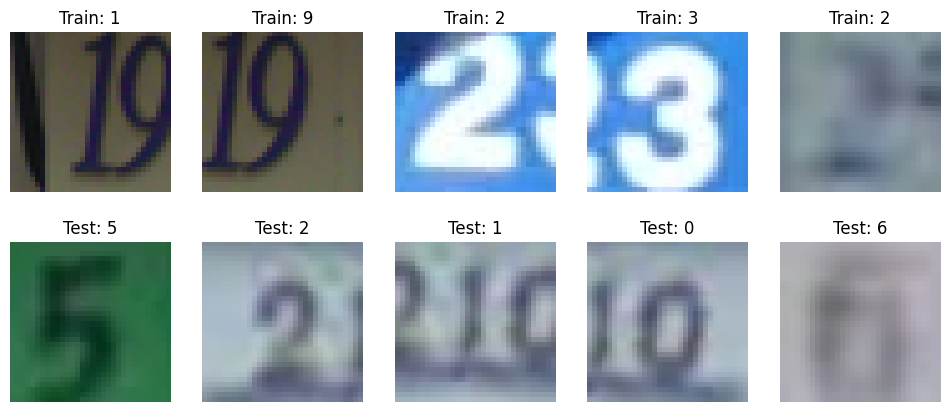

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    img, label = train[i]
    axes[0, i].imshow(img.permute(1, 2, 0))  # CHW -> HWC
    axes[0, i].set_title(f"Train: {label}")
    axes[0, i].axis("off")

    img, label = test[i]
    axes[1, i].imshow(img.permute(1, 2, 0))
    axes[1, i].set_title(f"Test: {label}")
    axes[1, i].axis("off")

plt.show()

#### 3.2.3 Freezing CLIP and training a classifier

For this question, we will be using a two layer feed forward neural network with a relu activation function in between as a classifier for the image embeddings outputted from CLIP

In [10]:
# getting the image embeddings dimension of clip for the first dimension (row wise) of the first layer
print(clip.projection_dim)

512


In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ClipClassifier(nn.Module):
    def __init__(self, n, clip_model):
        super().__init__()
        self.layer1 = nn.Linear(512, n)
        self.layer2 = nn.Linear(n, 10) #number of classes (0-9)
        self.clip = clip_model

        # freeze CLIP parameters
        for param in self.clip.parameters():
            param.requires_grad = False

    def forward(self, x):
        # use CLIP's vision model to get image embeddings
        with th.no_grad(): #no grad updates for the clip model
            vision_outputs = self.clip.vision_model(pixel_values=x)
            embeddings = self.clip.visual_projection(vision_outputs.pooler_output)

        # pass through the classifier layers (2)
        x = F.relu(self.layer1(embeddings))
        return self.layer2(x)


#### defining variables pre-train loop

In [12]:
from torch.utils.data import DataLoader
from PIL import Image
from transformers import CLIPProcessor

# load the CLIP processor for proper image preprocessing
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

def collate_fn(batch):
    imgs, labels = zip(*batch)

    # convert PyTorch tensors to PIL images (need to denormalize and convert to uint8)
    imgs_pil = []
    for img in imgs:
        # convert from CHW to HWC and rescale pixels to [0-255]
        img_np = (img.permute(1, 2, 0).numpy() * 255).astype('uint8')
        imgs_pil.append(Image.fromarray(img_np))

    # use CLIP processor to get the right dimensions
    inputs = processor(images=imgs_pil, return_tensors="pt")
    return inputs["pixel_values"], th.tensor(labels)

train_loader = DataLoader(train, 64, True, collate_fn=collate_fn)
test_loader = DataLoader(test, 64, False, collate_fn=collate_fn)
device = th.device("cuda" if th.cuda.is_available() else "cpu")

model = ClipClassifier(256, clip) #init device
model.to(device)
criterion = nn.CrossEntropyLoss() #cross entropy loss for classification task
optimizer = optim.Adam(model.parameters(), 0.001) #adam optimizer

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [13]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # reset optimizer gradients
        optimizer.zero_grad()
        output = model(data)
        # compute loss
        loss = criterion(output, target)
        #backprop
        loss.backward()
        #update
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # tracking
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')

    accuracy = 100. * correct / total
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

# evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with th.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # y: output
            output = model(data)

            #loss
            test_loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return test_loss, accuracy


In [14]:
# Main training loop
num_epochs = 5
print(f"Training on device: {device}")
print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters")

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 20)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

print('\nTraining completed!')


Training on device: cuda
Model has 133898 trainable parameters

Epoch 1/5
--------------------
Batch 0/1145, Loss: 2.317811
Batch 100/1145, Loss: 1.585487
Batch 200/1145, Loss: 1.494606
Batch 300/1145, Loss: 1.311141
Batch 400/1145, Loss: 1.433832
Batch 500/1145, Loss: 1.488338
Batch 600/1145, Loss: 1.308804
Batch 700/1145, Loss: 1.205976
Batch 800/1145, Loss: 1.237099
Batch 900/1145, Loss: 1.272087
Batch 1000/1145, Loss: 1.208436
Batch 1100/1145, Loss: 1.226805
Train Loss: 1.3110, Train Accuracy: 56.27%
Test Loss: 1.0070, Test Accuracy: 67.44%

Epoch 2/5
--------------------
Batch 0/1145, Loss: 1.229805
Batch 100/1145, Loss: 1.231278
Batch 200/1145, Loss: 0.820580
Batch 300/1145, Loss: 1.130349
Batch 400/1145, Loss: 1.088553
Batch 500/1145, Loss: 1.197918
Batch 600/1145, Loss: 1.314874
Batch 700/1145, Loss: 1.115594
Batch 800/1145, Loss: 0.937255
Batch 900/1145, Loss: 0.922059
Batch 1000/1145, Loss: 0.950768
Batch 1100/1145, Loss: 0.913503
Train Loss: 1.1084, Train Accuracy: 62.86%
Te